<a href="https://colab.research.google.com/github/silveiraluiza/machine-learning/blob/main/Abalone_Ensemble_M7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import urllib.request as ur
from google.colab import drive
import argparse
drive.mount('/content/gdrive')
from csv import reader
from math import sqrt
from random import seed
from random import randrange 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

seed(13)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Realizar experimento com a implementação de comitês bagging, boosting e stacking para a base de dados Abalone. Os modelos base para formação dos comitês deverão ser KNN, Árvore de Decisão e Redes Neurais Artificiais. Realizar uma busca de tal modo que os comitês apresentem desempenho superior ao desempenho solo dos classificadores. Desse modo, será necessário encontrar os modelos solo para a base de dados. Apresentar análise, os principais desafios encontrados para a construção dos comitês e conclusões.

# Tratamento inicial dos dados



In [ ]:
# Carregando os dados

data = pd.read_csv('/content/gdrive/My Drive/data/abalone_dataset.csv', sep =";")
data = pd.get_dummies(data) # one hot encoding para dados nominais
data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [ ]:
data.shape

(4177, 11)

In [ ]:
# Distribuição das classes
data[['rings']].groupby('rings')['rings'].count() # Contando a quantidade de classes e suas respectivas quantidades

rings
1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: rings, dtype: int64

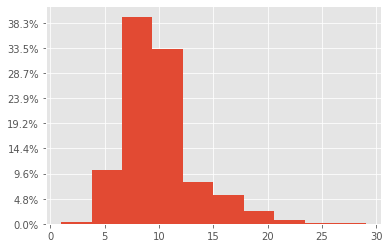

In [ ]:
from matplotlib.ticker import PercentFormatter

plt.style.use('ggplot')
plt.hist(data["rings"])
plt.gca().yaxis.set_major_formatter(PercentFormatter(4177))


## Preparando os dados

In [ ]:
# Dando uma nomenclatura de 0 até 27 para as classes para ficar mais simples 
def score_to_numeric(x):
    if x== 1:
        return 0
    if x== 2:
        return 1
    if x == 3:
        return 2
    if x == 4:
        return 3
    if x== 5:
        return 4
    if x== 6:
        return 5
    if x == 7:
        return 6
    if x == 8:
        return 7
    if x== 9:
        return 8
    if x== 10:
        return 9
    if x == 11:
        return 10
    if x == 12:
        return 11
    if x== 13:
        return 12
    if x== 14:
        return 13
    if x == 15:
        return 14
    if x == 16:
        return 15
    if x == 17:
        return 16
    if x== 18:
        return 17
    if x== 19:
        return 18
    if x == 20:
        return 19
    if x == 21:
        return 20
    if x== 22:
        return 21
    if x== 23:
        return 22
    if x == 24:
        return 23
    if x == 25:
        return 24
    if x== 26:
        return 25
    if x == 27:
        return 26
    if x== 29:
        return 27

# dar labels int de. 0 até 27 para as classes
data['rings'] = data['rings'].apply(score_to_numeric)


# Distribuição das classes
data[['rings']].groupby('rings')['rings'].count()

rings
0       1
1       1
2      15
3      57
4     115
5     259
6     391
7     568
8     689
9     634
10    487
11    267
12    203
13    126
14    103
15     67
16     58
17     42
18     32
19     26
20     14
21      6
22      9
23      2
24      1
25      1
26      2
27      1
Name: rings, dtype: int64

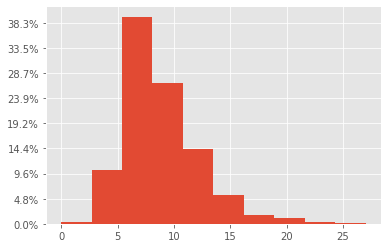

In [ ]:

plt.style.use('ggplot')
plt.hist(data["rings"])
plt.gca().yaxis.set_major_formatter(PercentFormatter(4177))

## Visualizando as relações entre as variáveis

<Figure size 576x576 with 0 Axes>

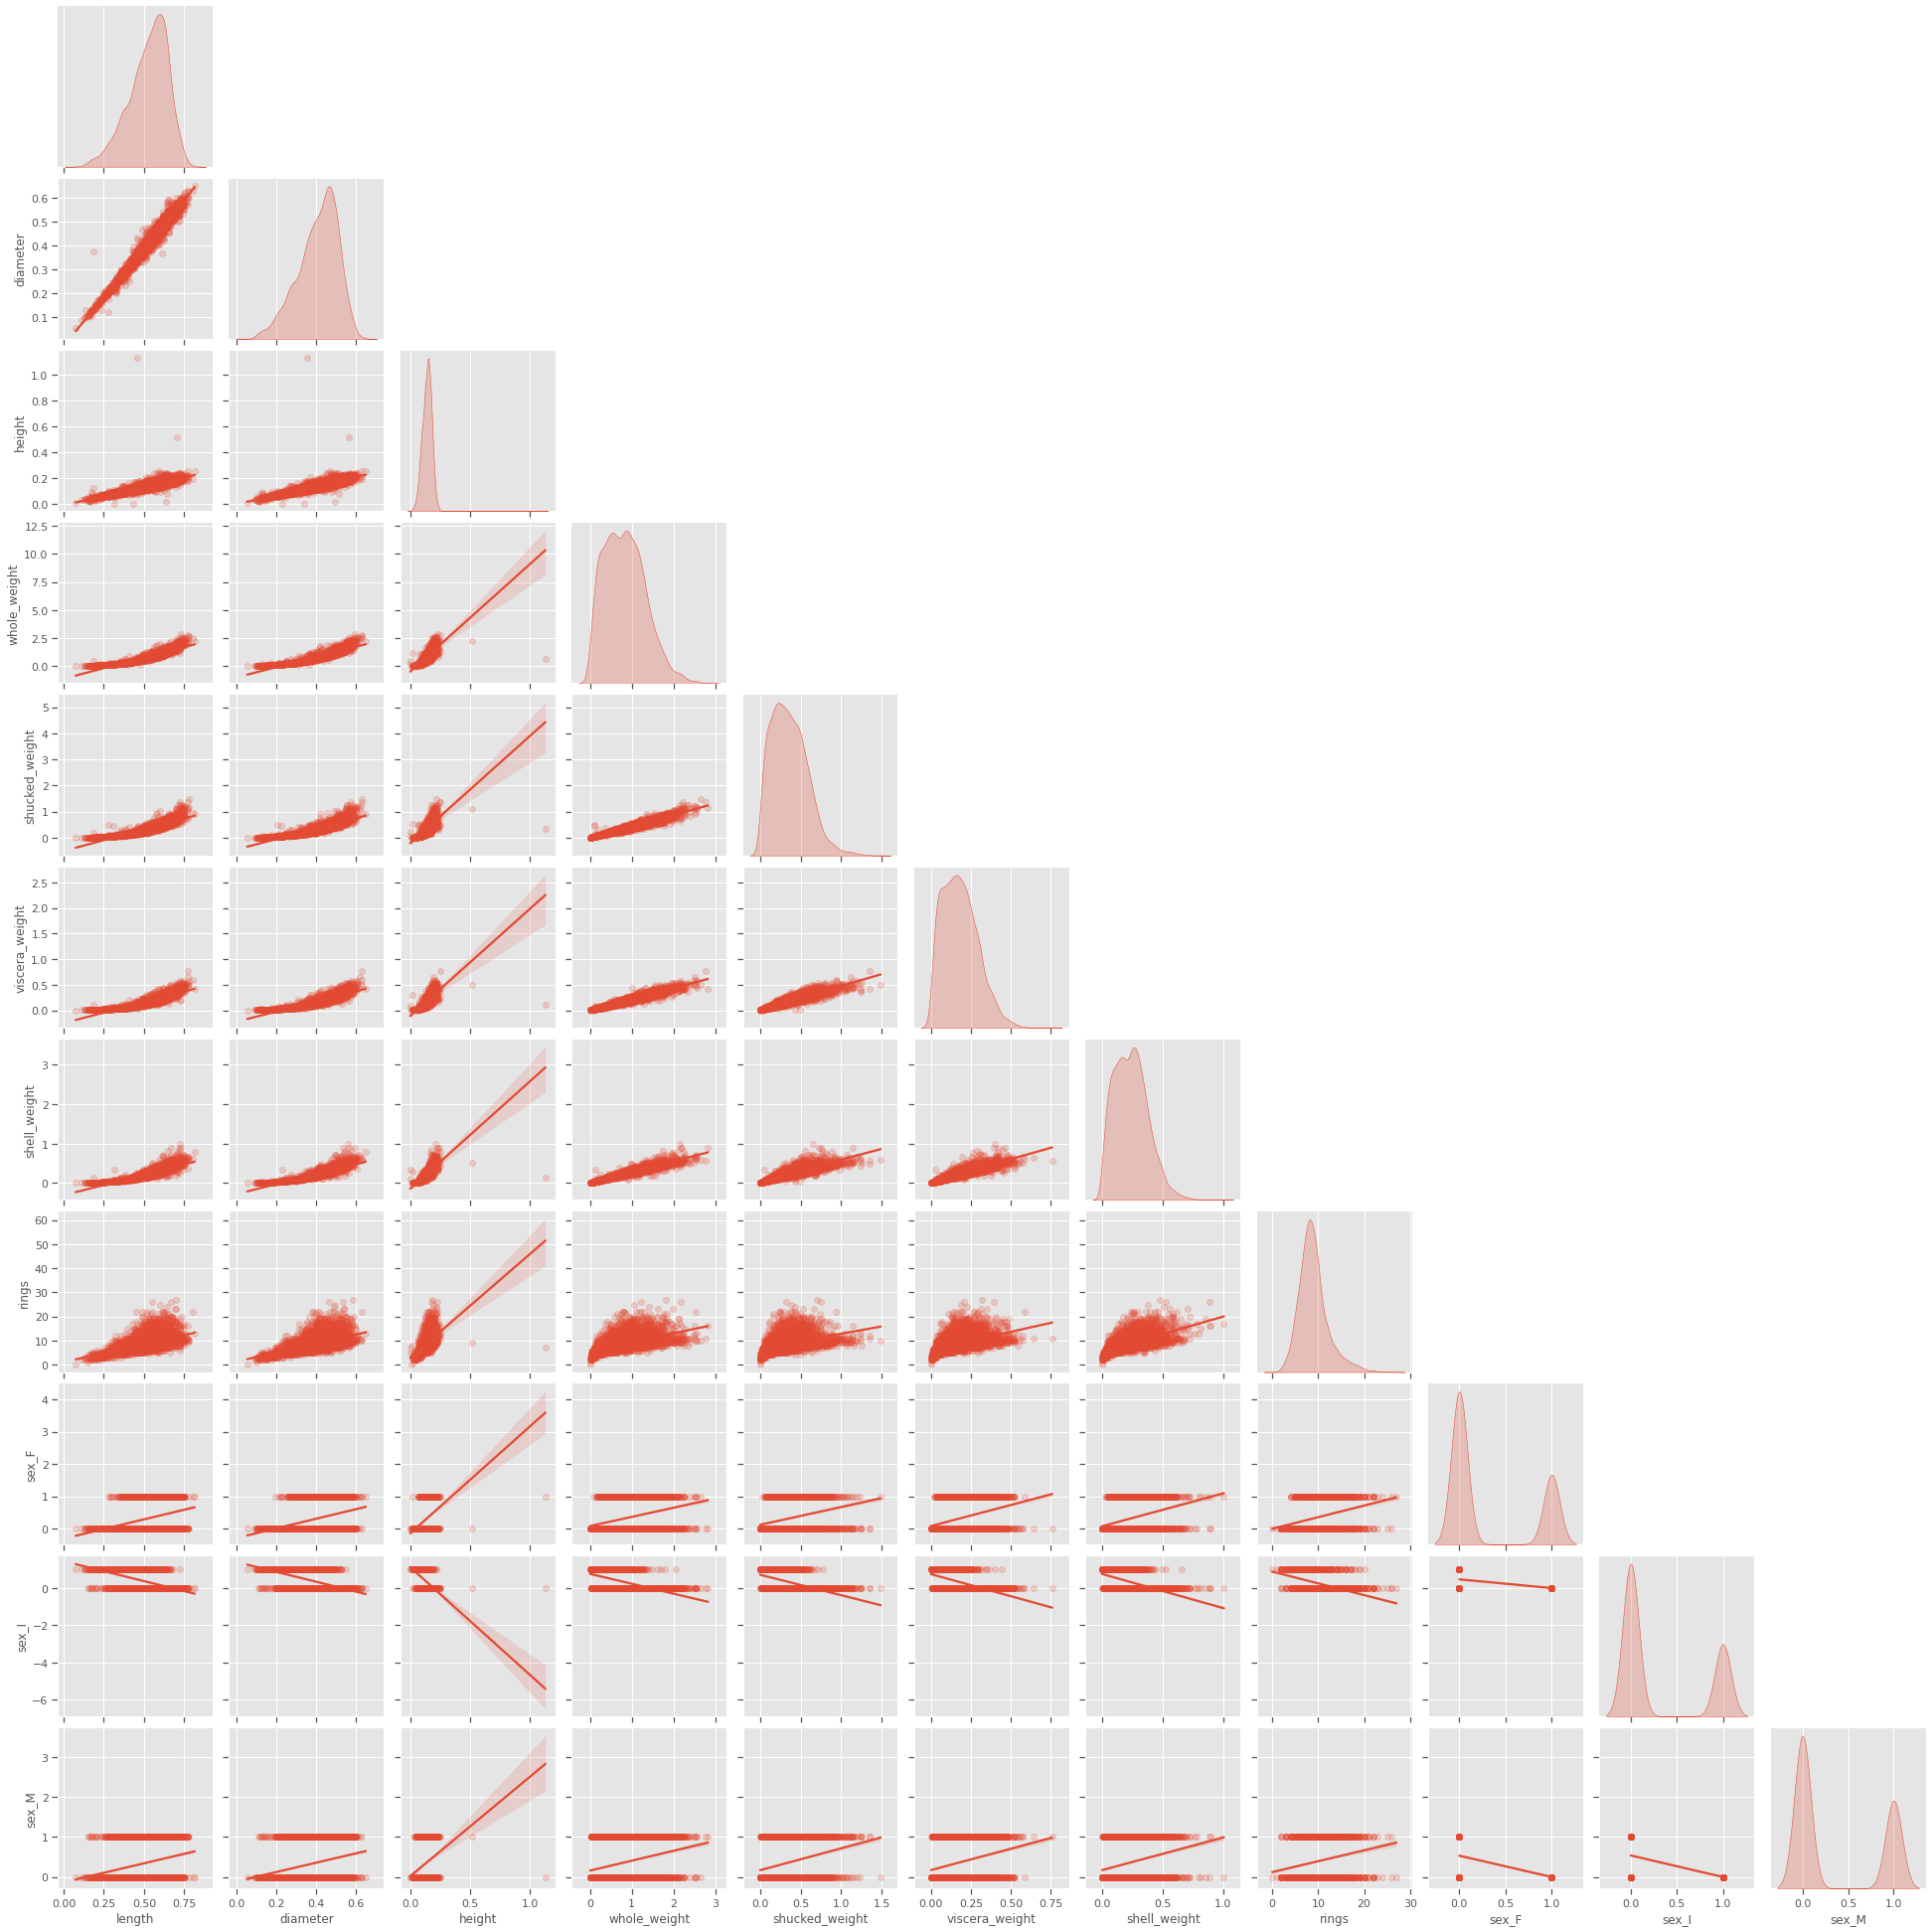

In [ ]:
sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
# Plotando a distribuição em pares das variáveis e seus histogramas
plt.figure(figsize=(8,8))
sns.pairplot(data, corner=True, kind="reg", diag_kind="kde", plot_kws={'scatter_kws': {'alpha': 0.2}})
plt.show()

## Matriz de correlação

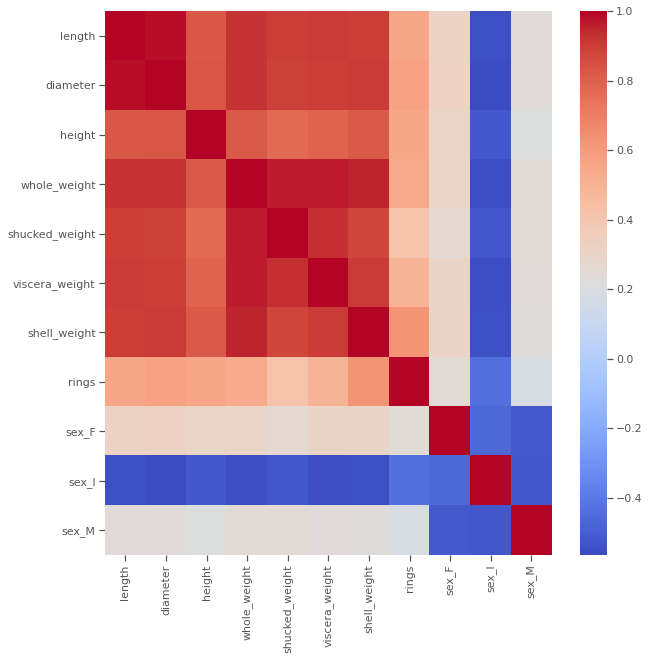

In [ ]:
# Visualizando a matriz de correlação
corr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap= 'coolwarm')
plt.show()

## Dados nulos

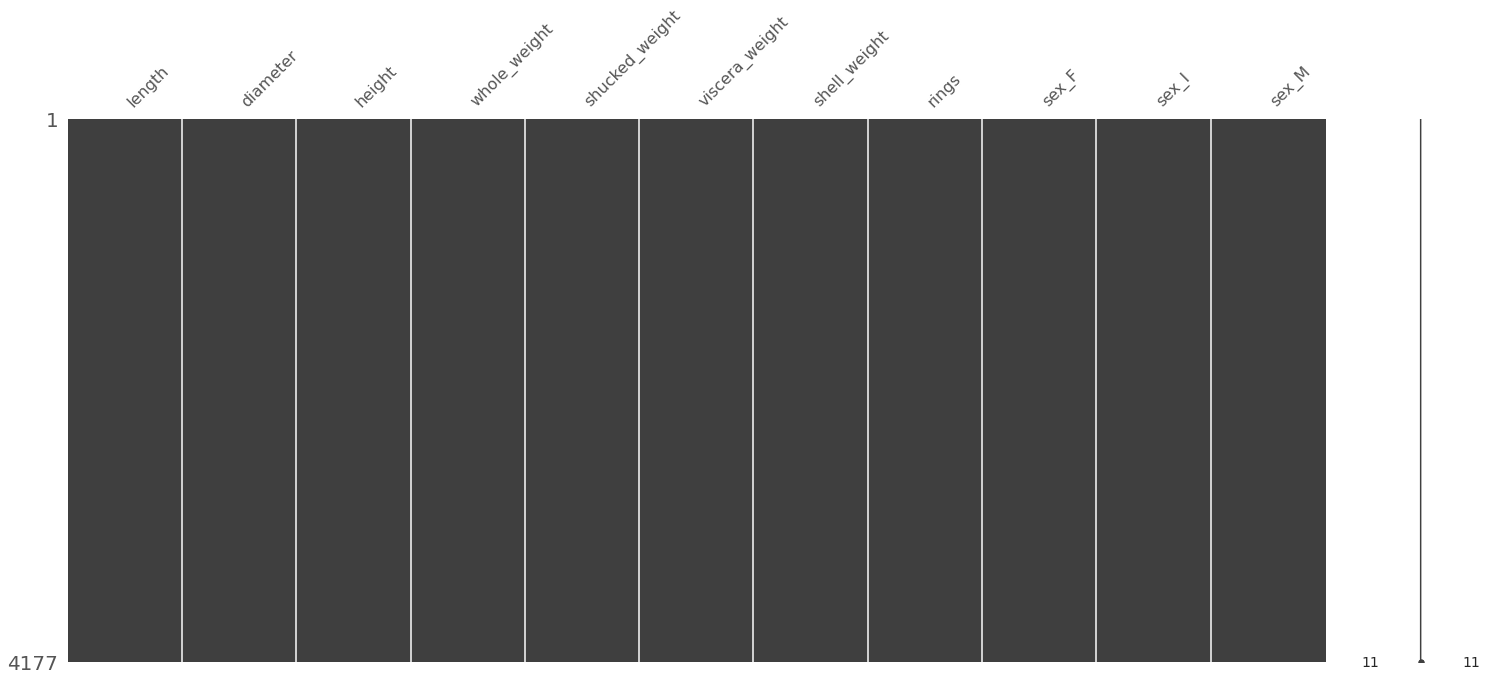

In [ ]:
import missingno as msno
msno.matrix(data)

Não há nenhum dado nulo a ser tratado nesse dataset

## Observação sobre treino e teste

Caso não fossemos realizar a cross-validation seria útil separar os dados únicos (observações onde só há uma classe) para ficarem apenas no treino, e não entrarem no dataset de teste, assim seria possível melhorar um pouco a predição e garantir uma extratificação mais completa.

In [ ]:
# Separando onde os dados são únicos para que fiquem obrigatóriamente no treino
apenas_1 = data.loc[(data['rings'] == 24) | (data['rings'] == 25) | (data['rings'] == 26) | (data['rings'] == 27) | (data['rings'] == 1) |( data['rings'] == 0)]	
tudo_com_mais_de_1 = data.loc[(data['rings'] != 24) & (data['rings'] != 25 )& (data['rings'] != 26) & (data['rings'] != 27) & (data['rings'] != 1) & (data['rings'] != 0)]
  

# Dividindo dataset em dados e labels
x = tudo_com_mais_de_1.drop(columns=['rings']).values
y = tudo_com_mais_de_1[['rings']].values # labels

x1 = apenas_1.drop(columns=['rings']).values
y1 = apenas_1[['rings']].values # labels

# treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify= y)

# adicionando os que só possuem 1 caso no treino
x_train = np.concatenate((x_train,x1))
y_train = np.concatenate((y_train,y1))

# Shapes
print(y_train.shape,
x_train.shape)

print(y_test.shape,
x_test.shape)

(3343, 1) (3343, 10)
(834, 1) (834, 10)


# Ensembles

## Stacking

Stacked Generalization ou simplesmente stacking é um algoritmo de aprendizagem de máquinas de ensemble.

Ele envolve a combinação das previsões de vários modelos de aprendizagem de máquina no mesmo conjunto de dados, assim como boosting e bagging.

O stacking aborda o questionamento a seguir:


>Dados os múltiplos modelos de aprendizagem de máquinas que são hábeis num problema, mas de formas diferentes, como se escolhe qual o modelo a utilizar?



A abordagem utilizada é usar outro modelo de aprendizagem de máquina que aprende quando utilizar ou confiar em cada modelo do conjunto.


A arquitetura de um modelo de empilhamento envolve dois ou mais modelos de base, frequentemente referidos como modelos de nível 0, e um meta-modelo que combina as previsões dos modelos de base, referidos como modelos de nível 1.

> 1. Modelos de nível-0 (Modelos de Base): Modelos treinados com os dados de treino e cujas previsões são compiladas.
> 2. Modelo de nível-1 (Meta-Modelo): Modelo que aprende a melhor forma de combinar as previsões dos modelos de base.


>knn 0.233 (0.015)
>dtree 0.202 (0.018)
>mlpclass 0.277 (0.022)
>stacking 0.275 (0.022)


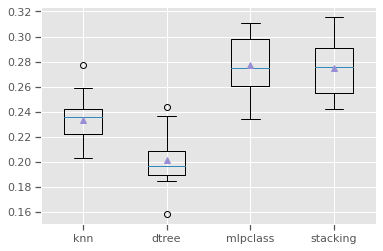

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot

seed = 1349
np.random.seed(seed)


X = data.drop(columns=['rings']).values
y = data[['rings']].values # labels

def get_stacking():
  # Definindo os modelos base do stacking
  level0 = list()
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('dtree', DecisionTreeClassifier()))
  level0.append(('mlpclass', MLPClassifier()))
	# definindo o modelo meta learner 
  level1 = LogisticRegression()
  # definindo o ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model
 
# função retorna os modelos a serem avaliados
def get_models():
  models = dict()
  models['knn'] = KNeighborsClassifier()
  models['dtree'] = DecisionTreeClassifier()
  models['mlpclass'] = MLPClassifier()
  models['stacking'] = get_stacking()
  return models
 
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Entre os modelos baseline o MLP é o que mais se destaca, com uma acurácia de 0.277 e o desvio padrão de 0.022.


O modelo de stacking obteve uma média de acurácia maior que os demais (knn e decision tree) no entanto uma performance semelhante com o MLP. É interessante notar que o desvio padrão do stacking é o maior encontrado, muito provavelmente devido ao fato de que o mesmo realiza a combinação dos modelos. Foram também analisados outros modelos meta learners com o stacking (KNN, DecisionTree e MLP) no entanto a regressão logística seguiu sendo o que obteve a melhor performance.

## Bagging

Um classificador Bagging é um meta-estimador de conjunto que encaixa os classificadores de base cada um em subconjuntos aleatórios do conjunto de dados original e depois agrega as suas previsões individuais (seja por votação ou por média) para formar uma previsão final. 

Tal meta-estimador pode tipicamente ser usado como uma forma de reduzir a variância de um estimador caixa preta (por exemplo, uma árvore de decisão) ao introduzir a aleatorização no seu procedimento de construção e depois fazendo um conjunto a partir dela.


>DecisionTreeClassifier 0.230 (0.022)
>KNeighborsClassifier 0.239 (0.018)
>MLPClassifier 0.274 (0.024)


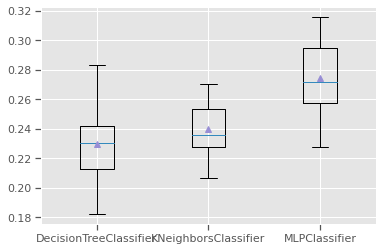

In [ ]:
from sklearn.ensemble import BaggingClassifier

seed = 1349
np.random.seed(seed)

def get_models():
  models = dict()
  # Variando o número de árvores
  n_trees = [10] # por questões de performance da máquina não foi possível testar com mais de 10 árvores, o mlp se torna muito custoso

  dtree = DecisionTreeClassifier()
  knn = KNeighborsClassifier()
  mlp = MLPClassifier()

  # Variando os modelos
  base_estimators = [dtree, knn, mlp]
  for n in n_trees:
    for b in base_estimators:
      models[b.__class__.__name__] = BaggingClassifier(n_estimators=n, base_estimator = b)
  return models
 
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
 

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Para o bagging houve sim uma melhoria na maioria dos modelos ao se comparar os modelos base e os com aplicação da técnica, principalmente no de árvore de decisão, no entanto é curioso notar que não houve uma diminuição do desvio padrão como é esperado para esse método.

## Boosting

Os métodos de boosting funcionam na mesma lógica que os métodos de bagging: construímos uma família de modelos que são agregados para obter um *learner* forte que tenha um melhor desempenho. 

No entanto, ao contrário do bagging que visa principalmente reduzir a variância, o boosting é uma técnica que consiste em encaixar sequencialmente vários *learners* fracos de uma forma muito adaptativa: cada modelo na sequência é encaixado dando mais importância às observações no conjunto de dados que foram mal tratadas pelos modelos anteriores na sequência. 

Intuitivamente, cada novo modelo concentra os seus esforços nas observações mais difíceis de encaixar até agora, de modo a obter, no final do processo, um *learner* forte com menor bias (mesmo que se note que o boosting também pode ter o efeito de reduzir a variância). O boosting, tal como o bagging, pode ser utilizado para a regressão, bem como para problemas de classificação.


>10 0.201 (0.020)
>15 0.201 (0.021)
>25 0.200 (0.017)
>50 0.201 (0.017)
>100 0.202 (0.016)
>500 0.201 (0.019)
>1000 0.199 (0.017)


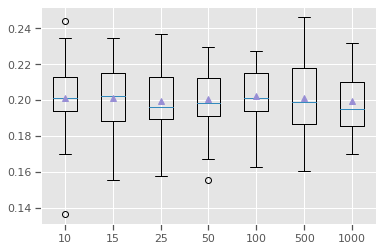

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

seed = 1349
np.random.seed(seed)

def get_models():
  models = dict()
  # Variando o número de árvores
  n_trees = [10, 15, 25, 50, 100, 500, 1000] 
  dtree = DecisionTreeClassifier()
  knn = KNeighborsClassifier()
  mlp = MLPClassifier()

  # Variando os modelos
  base_estimators = [dtree] # não é possível realizar a variação dos modelos pois é necessário 
  # suporte para sample weighting, bem como atributos classes_ e n_classes_ adequados. 
  for n in n_trees:
    for b in base_estimators:
      models[str(n)] = AdaBoostClassifier(n_estimators=n, base_estimator = b)
  return models
 
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
 

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Para somente o caso do adaboost com árvore de decisão obtivemos uma melhora, principalmente no caso onde 100 árvores são utilizadas.

## Diferentes Boostings apenas com árvore de decisão

In [ ]:

seed = 1349
np.random.seed(seed)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import EnsembleVoteClassifier

ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()
boost_array = [ada_boost, grad_boost, xgb_boost]
eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']
results, names = list(), list()

for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))
    results.append(scores)



Mean: 0.214, std: (+/-) 0.030 [Ada Boost]
Mean: 0.257, std: (+/-) 0.029 [Grad Boost]
Mean: 0.266, std: (+/-) 0.032 [XG Boost]
Mean: 0.253, std: (+/-) 0.034 [Ensemble]


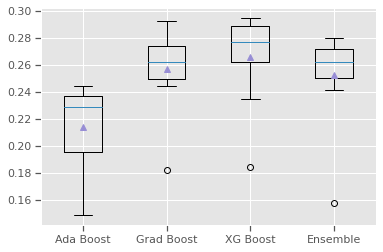

In [ ]:
pyplot.boxplot(results, labels=labels, showmeans=True)
pyplot.show()

Com os diversos modelos de boosting o XGBoost se destaca, sendo melhor até que o ensemble de todos os modelos

## Principais desafios


1.   Tempo de execução do algoritmo MLP;
2.   Baixa acurácia dos modelos, muito provavelmente devido ao número extremamente desbalanceado de classes, algo que poderia ser "resolvido" com agrupamento das mesmas para fazer a predição com um número de classes reduzidas e mais balanceadas;
3. Houve certa dificuldade para compreender bem o boosting e o bagging e o que cada um precisava como entrada.



## Conclusões

Apesar de não ter obtido nenhum ensemble melhor do que o classificador MLP, os processos de passar por cada etapa da criação de cada ensemble foram bastante úteis. É também possível ver que em cada método houve uma melhoria perceptível da acurácia dos resultados ao utilizar as técnicas ensemble (salvo o caso do MLP).

Caso houvesse acesso a uma máquina mais potente poderiamos ter gasto mais tempo para testes e afinação de hiperparâmetros para avaliar melhor cada cenário e obter resultados mais satisfatórios. A comparação dos resultados foi uma tarefa que foi facilitada pelo uso dos gráficos de boxplot.

O ponto principal da atividade foi mostrar que a modelação de conjuntos pode produzir melhores previsões, e isto foi alcançado.
